In [21]:
import sys
sys.path.append("../")  # Add repo path

import warnings
warnings.filterwarnings("ignore")

import pandas as pd       # For data manipulation and analysis
import numpy as np        # For numerical operations and handling arrays
import matplotlib.pyplot as plt  # For plotting]
import os
from mbt_gym.gym.helpers.visualize_return import *

# Get the current working directory and then go up to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Amazon

In [22]:
message_data = pd.read_csv("AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)
# message_data = pd.read_csv("_data_dwn_43_456__AMZN_2024-08-01_2024-08-01_10/AMZN_2024-08-01_24900000_57900000_message_10.csv", header=None)

message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction'     # -1 for sell, 1 for buy
]

message_data.columns = message_column_names

print(message_data.shape)

message_data.head()


(269748, 6)


,Time,EventType,OrderID,Size,Price,Direction
0,34200.017460,5,0,1,2238200,-1
1,34200.189608,1,11885113,21,2238100,1
2,34200.189608,1,3911376,20,2239600,-1
3,34200.189608,1,11534792,100,2237500,1
4,34200.189608,1,1365373,13,2240000,-1


In [23]:
book_data = pd.read_csv("AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
# book_data = pd.read_csv("_data_dwn_43_456__AMZN_2024-08-01_2024-08-01_10/AMZN_2024-08-01_24900000_57900000_orderbook_10.csv", header=None)

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

book_data.head()

(269748, 40)


,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,2239500,100,2231800,100,2239900,100,2230700,200,2240000,220,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,2239500,100,2238100,21,2239900,100,2231800,100,2240000,220,...,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,2239500,100,2238100,21,2239600,20,2231800,100,2239900,100,...,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,2239500,100,2238100,21,2239600,20,2237500,100,2239900,100,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


## Investigate Inter-Arrival Times

In [24]:
message_data['InterArrivalTimes'] = message_data['Time'].diff()
message_data.head()

,Time,EventType,OrderID,Size,Price,Direction,InterArrivalTimes
0,34200.017460,5,0,1,2238200,-1,NaN
1,34200.189608,1,11885113,21,2238100,1,0.172148
2,34200.189608,1,3911376,20,2239600,-1,0.000000
3,34200.189608,1,11534792,100,2237500,1,0.000000
4,34200.189608,1,1365373,13,2240000,-1,0.000000


Mean of Interarrival Times (in MS): 86.74773732435577
Standard Deviation of Interarrival Times: 0.318267040507413
Coefficient of Variation (CV): 3.66888002297271


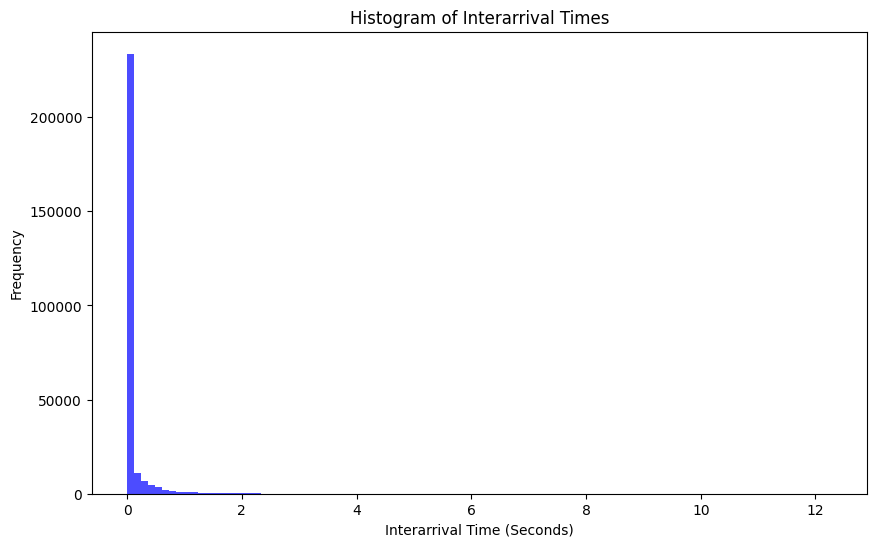

In [25]:
# Remove the first item as it is NaN
interarrival_times = message_data['InterArrivalTimes'].dropna()

# 1. Check Standard Deviation
mean_interarrival = interarrival_times.mean()
std_interarrival = interarrival_times.std()
cv_interarrival = std_interarrival / mean_interarrival  # Coefficient of Variation

print(f"Mean of Interarrival Times (in MS): {mean_interarrival * 1000}")
print(f"Standard Deviation of Interarrival Times: {std_interarrival}")
print(f"Coefficient of Variation (CV): {cv_interarrival}")

# Interpretation:
# - A low standard deviation relative to the mean (or a low CV) suggests the data is roughly constant.

# 2. Plot a histogram of Interarrival Times
plt.figure(figsize=(10, 6))
plt.hist(interarrival_times, bins=100, alpha=0.7, color='blue')
plt.xlabel('Interarrival Time (Seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Interarrival Times')
plt.show()

## Regularize data to the same time interval

In [26]:
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

start_time = book_data['Time'].iloc[0]
end_time = book_data['Time'].iloc[-1]

print("First row Time:", start_time)
print("Last row Time:", end_time)

book_data.head()

First row Time: 34200.017459617
Last row Time: 57599.95935965


,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,34200.017460,2239500,100,2231800,100,2239900,100,2230700,200,2240000,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,34200.189608,2239500,100,2238100,21,2239900,100,2231800,100,2240000,...,2204000,100,2294300,100,2202500,5000,2298000,100,2202000,100
2,34200.189608,2239500,100,2238100,21,2239600,20,2231800,100,2239900,...,2204000,100,2267700,100,2202500,5000,2294300,100,2202000,100
3,34200.189608,2239500,100,2238100,21,2239600,20,2237500,100,2239900,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000
4,34200.189608,2239500,100,2238100,21,2239600,20,2237500,100,2239900,...,2213000,4000,2267700,100,2204000,100,2294300,100,2202500,5000


In [27]:
# Make a deep copy of book_data to preserve the original data
book_data_unique = book_data.copy(deep=True)

# Drop duplicate times, keeping only the last occurrence for each unique time
book_data_unique = book_data_unique.drop_duplicates(subset='Time', keep='last')

# Set 'Time' as the index for the unique book_data
book_data_unique = book_data_unique.set_index('Time')

In [28]:
# Generate the regular time index with 100 ms intervals (0.1 seconds)
regular_times = np.arange(start_time, end_time, 0.1)  # 0.1 seconds = 100 ms

# Reindex book_data_unique to the new 100 ms regular time index, forward-filling missing values
regularized_book_data = book_data_unique.reindex(regular_times, method='ffill')

# Reset the index to make 'Time' a column again in regularized_book_data
regularized_book_data.reset_index(inplace=True)
regularized_book_data.rename(columns={'index': 'Time'}, inplace=True)

print(regularized_book_data.shape)

# Display the first few rows to verify
regularized_book_data.head()

(234000, 41)


,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,34200.01746,2239500,100,2231800,100,2239900,100,2230700,200,2240000,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
1,34200.11746,2239500,100,2231800,100,2239900,100,2230700,200,2240000,...,2202500,5000,2294300,100,2202000,100,2298000,100,2189700,100
2,34200.21746,2239500,100,2237500,74,2239600,20,2236500,2,2239900,...,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100
3,34200.31746,2239500,100,2237500,74,2239600,20,2236500,2,2239900,...,2226200,100,2244900,100,2213000,4000,2245000,5,2204000,100
4,34200.41746,2240000,517,2237500,74,2242400,20,2236500,2,2242500,...,2230000,10,2267700,100,2226200,100,2294300,100,2213000,4000


Percentage of rows with no change in MidPrice: 95.2735%
(234000, 42)


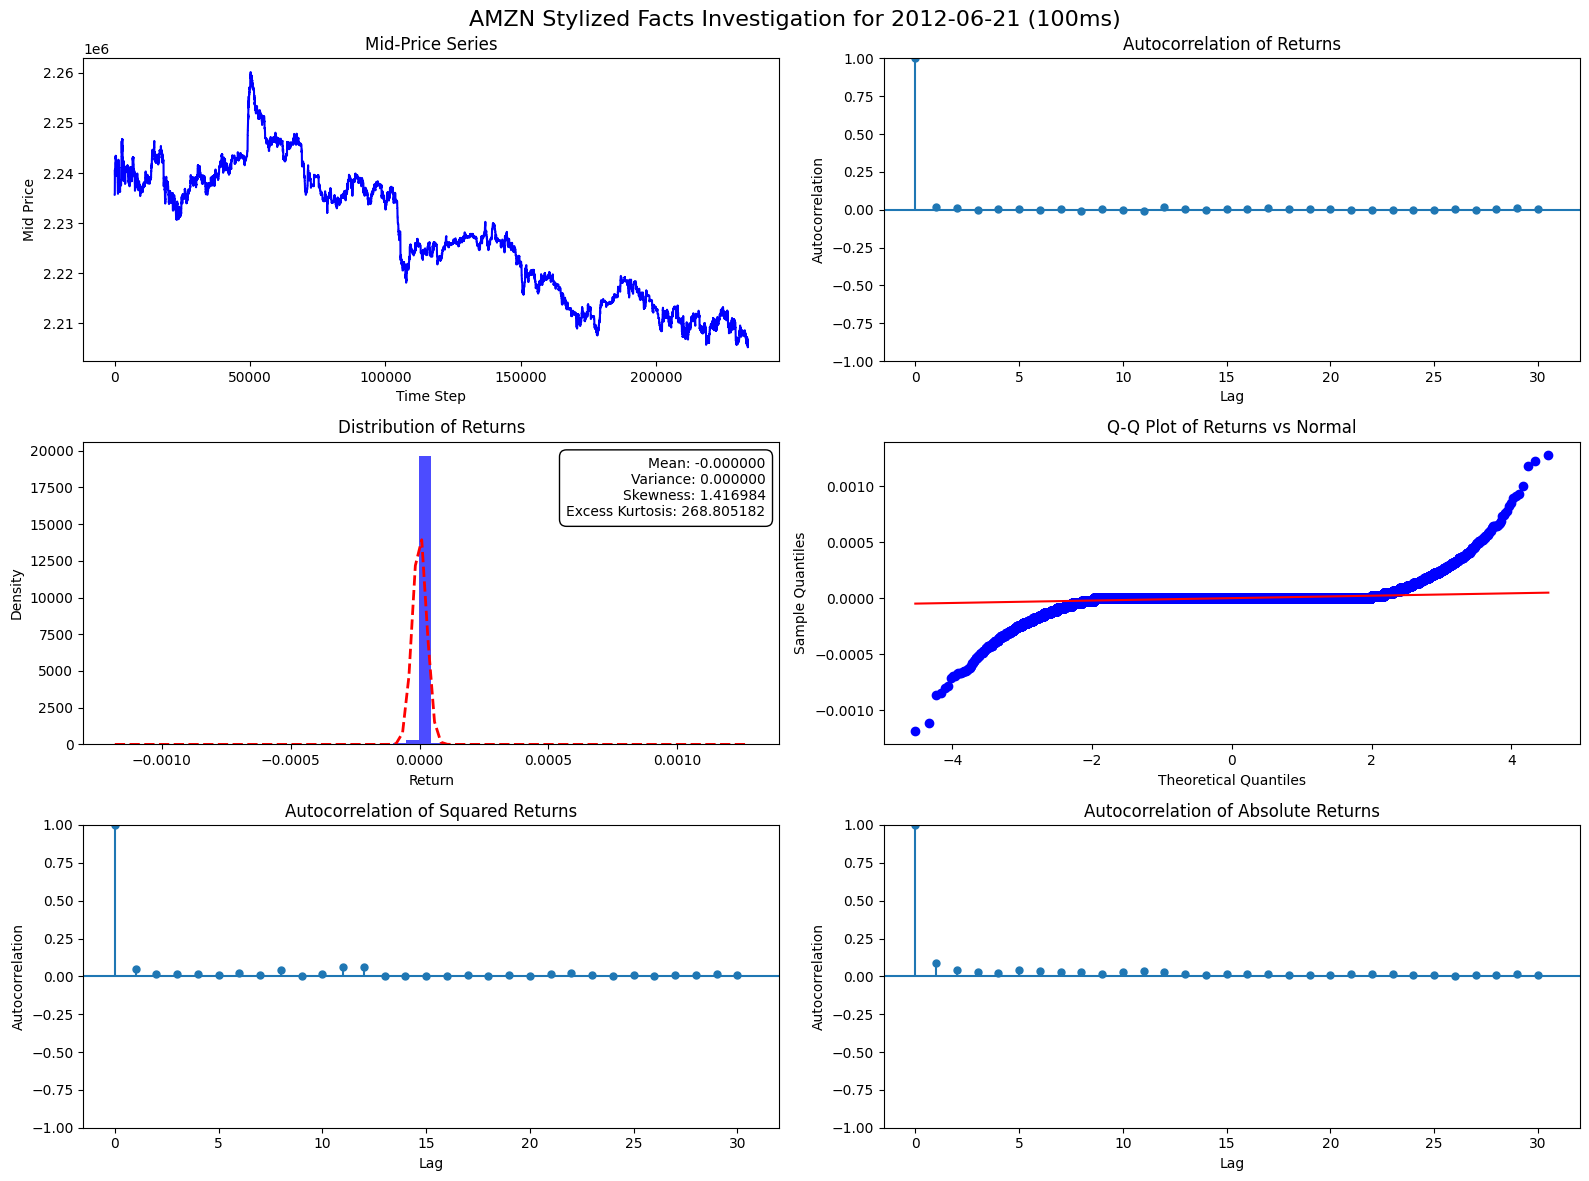

In [29]:
regularized_book_data['MidPrice'] = (regularized_book_data['AskPrice1'] + regularized_book_data['BidPrice1']) / 2

# Calculate the difference between consecutive rows in the 'MidPrice' column
mid_price_diff = regularized_book_data['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count = (mid_price_diff == 0).sum()

# Calculate the percentage of zero changes
percentage_zero_changes = (zero_change_count / len(regularized_book_data)) * 100

print(f"Percentage of rows with no change in MidPrice: {percentage_zero_changes:.4f}%")
print(regularized_book_data.shape)

visualize_return(regularized_book_data['MidPrice'], "AMZN Stylized Facts Investigation for 2012-06-21 (100ms)")

Percentage of rows with no change in MidPrice in book_data: 89.7838%
(269748, 42)


KeyboardInterrupt: 

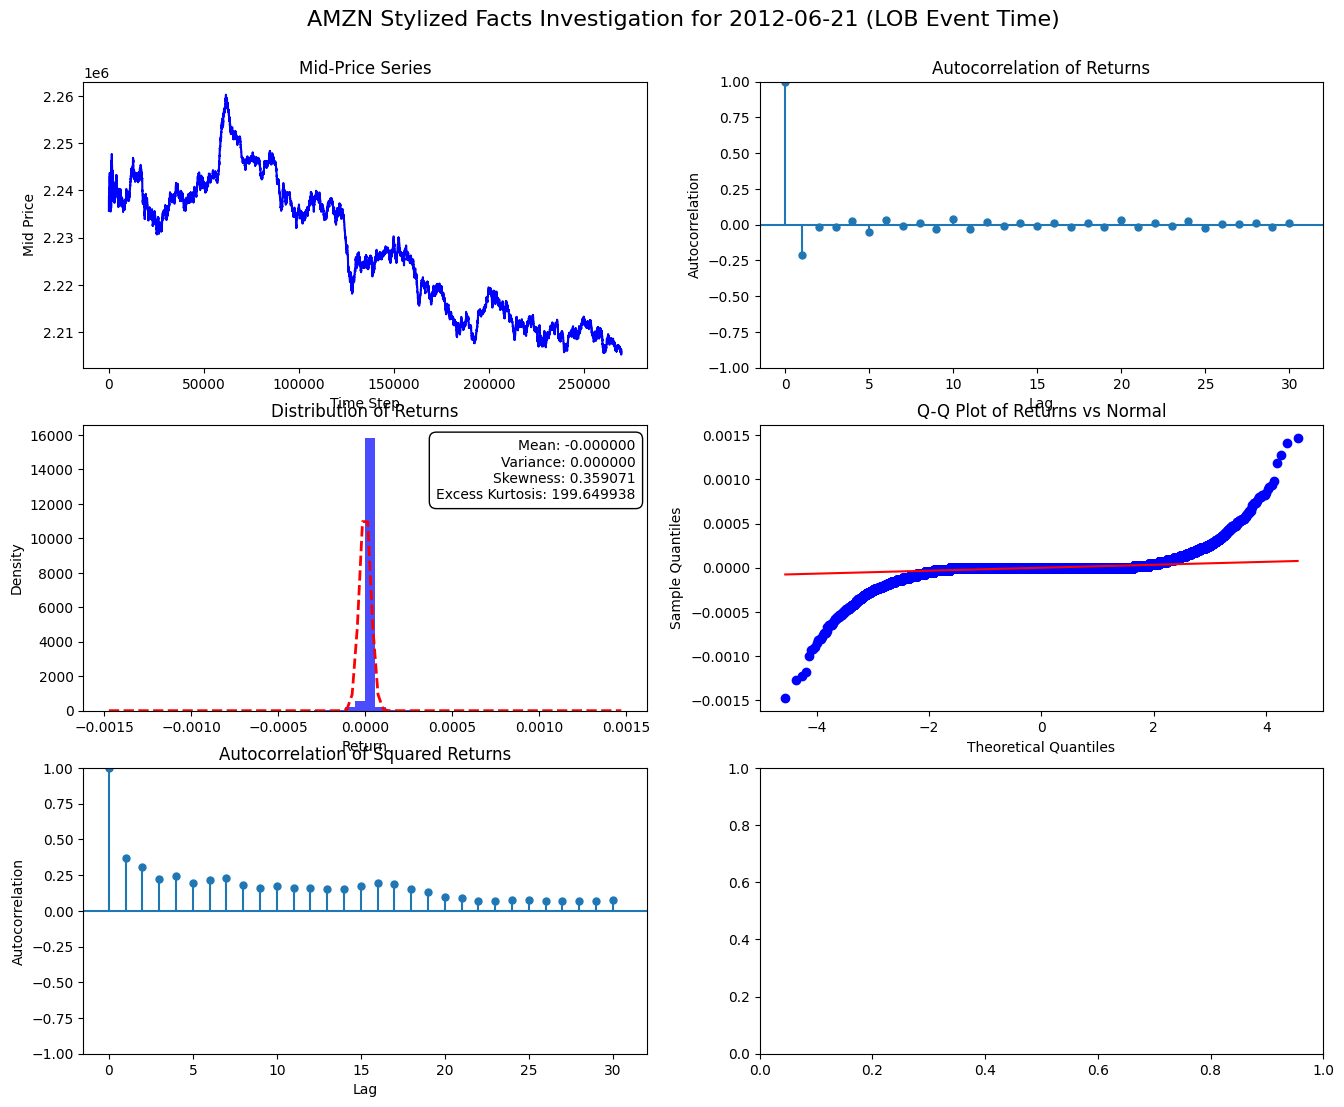

In [30]:
book_data['MidPrice'] = (book_data['AskPrice1'] + book_data['BidPrice1']) / 2

# Calculate the difference between consecutive rows in the 'MidPrice' column for book_data
mid_price_diff_original = book_data['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count_original = (mid_price_diff_original == 0).sum()

# Calculate the percentage of zero changes in book_data
percentage_zero_changes_original = (zero_change_count_original / len(book_data)) * 100

print(f"Percentage of rows with no change in MidPrice in book_data: {percentage_zero_changes_original:.4f}%")

print(book_data.shape)

visualize_return(book_data['MidPrice'], "AMZN Stylized Facts Investigation for 2012-06-21 (LOB Event Time)")

Percentage of rows with no change in MidPrice in market order events: 47.8851%
(11419, 42)


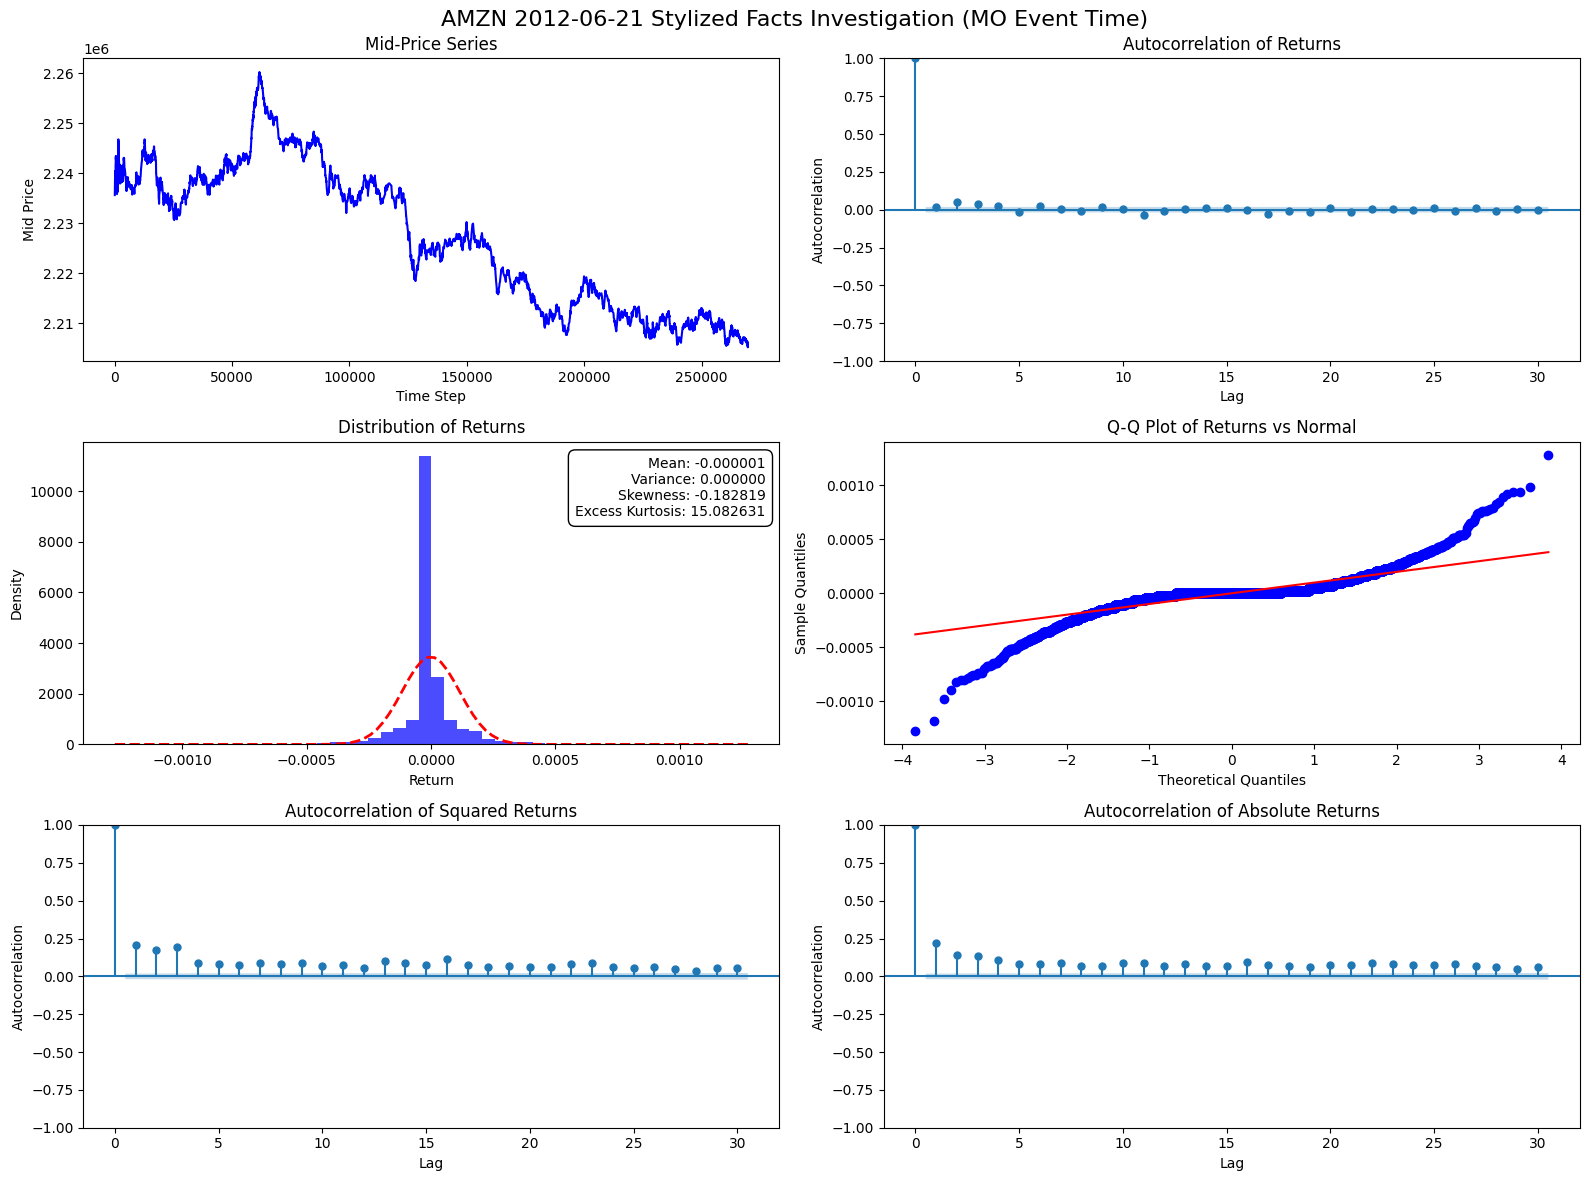

In [ ]:
# Step 1: Filter for market order events (EventType 4 and 5)
market_order_events = book_data[message_data['EventType'].isin([4, 5])].copy(deep=True)

# All midprice divided by 1e4 to scale to dollars
market_order_events['MidPrice'] = market_order_events['MidPrice'] / 1e4

# Step 2: Calculate the Mid-Price at each market order event
market_order_events['MidPrice'] = (market_order_events['AskPrice1'] + market_order_events['BidPrice1']) / 2

# Step 3: Calculate the difference between consecutive rows in the 'MidPrice' column
mid_price_diff_event_time = market_order_events['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count_event_time = (mid_price_diff_event_time == 0).sum()

# Calculate the percentage of zero changes in market order events
percentage_zero_changes_event_time = (zero_change_count_event_time / len(market_order_events)) * 100

# Print the result
print(f"Percentage of rows with no change in MidPrice in market order events: {percentage_zero_changes_event_time:.4f}%")

print(market_order_events.shape)

# Step 4: Visualize the return series for MidPrice at market order event times
visualize_return(market_order_events['MidPrice'], "AMZN 2012-06-21 Stylized Facts Investigation (MO Event Time)")

# GOOGLE

In [ ]:
message_data = pd.read_csv("GOOG_2012-06-21_34200000_57600000_message_10.csv", header=None)
# message_data = pd.read_csv("_data_dwn_43_456__MSFT_2024-08-01_2024-09-01_10/MSFT_2024-08-01_34200000_57600000_message_10.csv", header=None)


message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction'     # -1 for sell, 1 for buy
]

message_data.columns = message_column_names

print(message_data.shape)

message_data.head()

(147916, 6)


,Time,EventType,OrderID,Size,Price,Direction
0,34200.015105,4,15818974,4,5794000,1
1,34200.059902,4,15818974,300,5794000,1
2,34200.113247,5,0,1,5795100,1
3,34200.113247,5,0,1,5795000,1
4,34200.113247,5,0,1,5794900,1


In [ ]:
book_data = pd.read_csv("GOOG_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
# book_data = pd.read_csv("_data_dwn_43_456__MSFT_2024-08-01_2024-09-01_10/MSFT_2024-08-01_34200000_57600000_orderbook_10.csv", header=None)

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

book_data.head()

(147916, 40)


,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,5802300,100,5794000,496,5804300,100,5787000,400,5805000,100,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
1,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
2,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
3,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
4,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100


In [ ]:
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

start_time = book_data['Time'].iloc[0]
end_time = book_data['Time'].iloc[-1]

print("First row Time:", start_time)
print("Last row Time:", end_time)

book_data.head()

First row Time: 34200.015105074
Last row Time: 57599.871751084


,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,34200.015105,5802300,100,5794000,496,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
1,34200.059902,5802300,100,5794000,196,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
2,34200.113247,5802300,100,5794000,196,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
3,34200.113247,5802300,100,5794000,196,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
4,34200.113247,5802300,100,5794000,196,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100


In [ ]:
# Make a deep copy of book_data to preserve the original data
book_data_unique = book_data.copy(deep=True)

# Drop duplicate times, keeping only the last occurrence for each unique time
book_data_unique = book_data_unique.drop_duplicates(subset='Time', keep='last')

# Set 'Time' as the index for the unique book_data
book_data_unique = book_data_unique.set_index('Time')

In [ ]:
# Generate the regular time index with 100 ms intervals (0.1 seconds)
regular_times = np.arange(start_time, end_time, 0.1)  # 0.1 seconds = 100 ms

# Reindex book_data_unique to the new 100 ms regular time index, forward-filling missing values
regularized_book_data = book_data_unique.reindex(regular_times, method='ffill')

# Reset the index to make 'Time' a column again in regularized_book_data
regularized_book_data.reset_index(inplace=True)
regularized_book_data.rename(columns={'index': 'Time'}, inplace=True)

# Display the first few rows to verify
regularized_book_data.head()

,Time,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
0,34200.015105,5802300,100,5794000,496,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
1,34200.115105,5802300,100,5794000,29,5804300,100,5787000,400,5805000,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
2,34200.215105,5798900,25,5794000,99,5799500,50,5791200,100,5799800,...,5780000,674,5806300,100,5779900,1,5809600,50,5766000,100
3,34200.315105,5798900,25,5794000,59,5799500,50,5791900,75,5799800,...,5782100,10,5806300,100,5780000,674,5809600,50,5779900,1
4,34200.415105,5798900,25,5794000,59,5799500,50,5791900,75,5799800,...,5782100,10,5806300,100,5780000,674,5809600,50,5779900,1


Percentage of rows with no change in MidPrice: 96.2329%


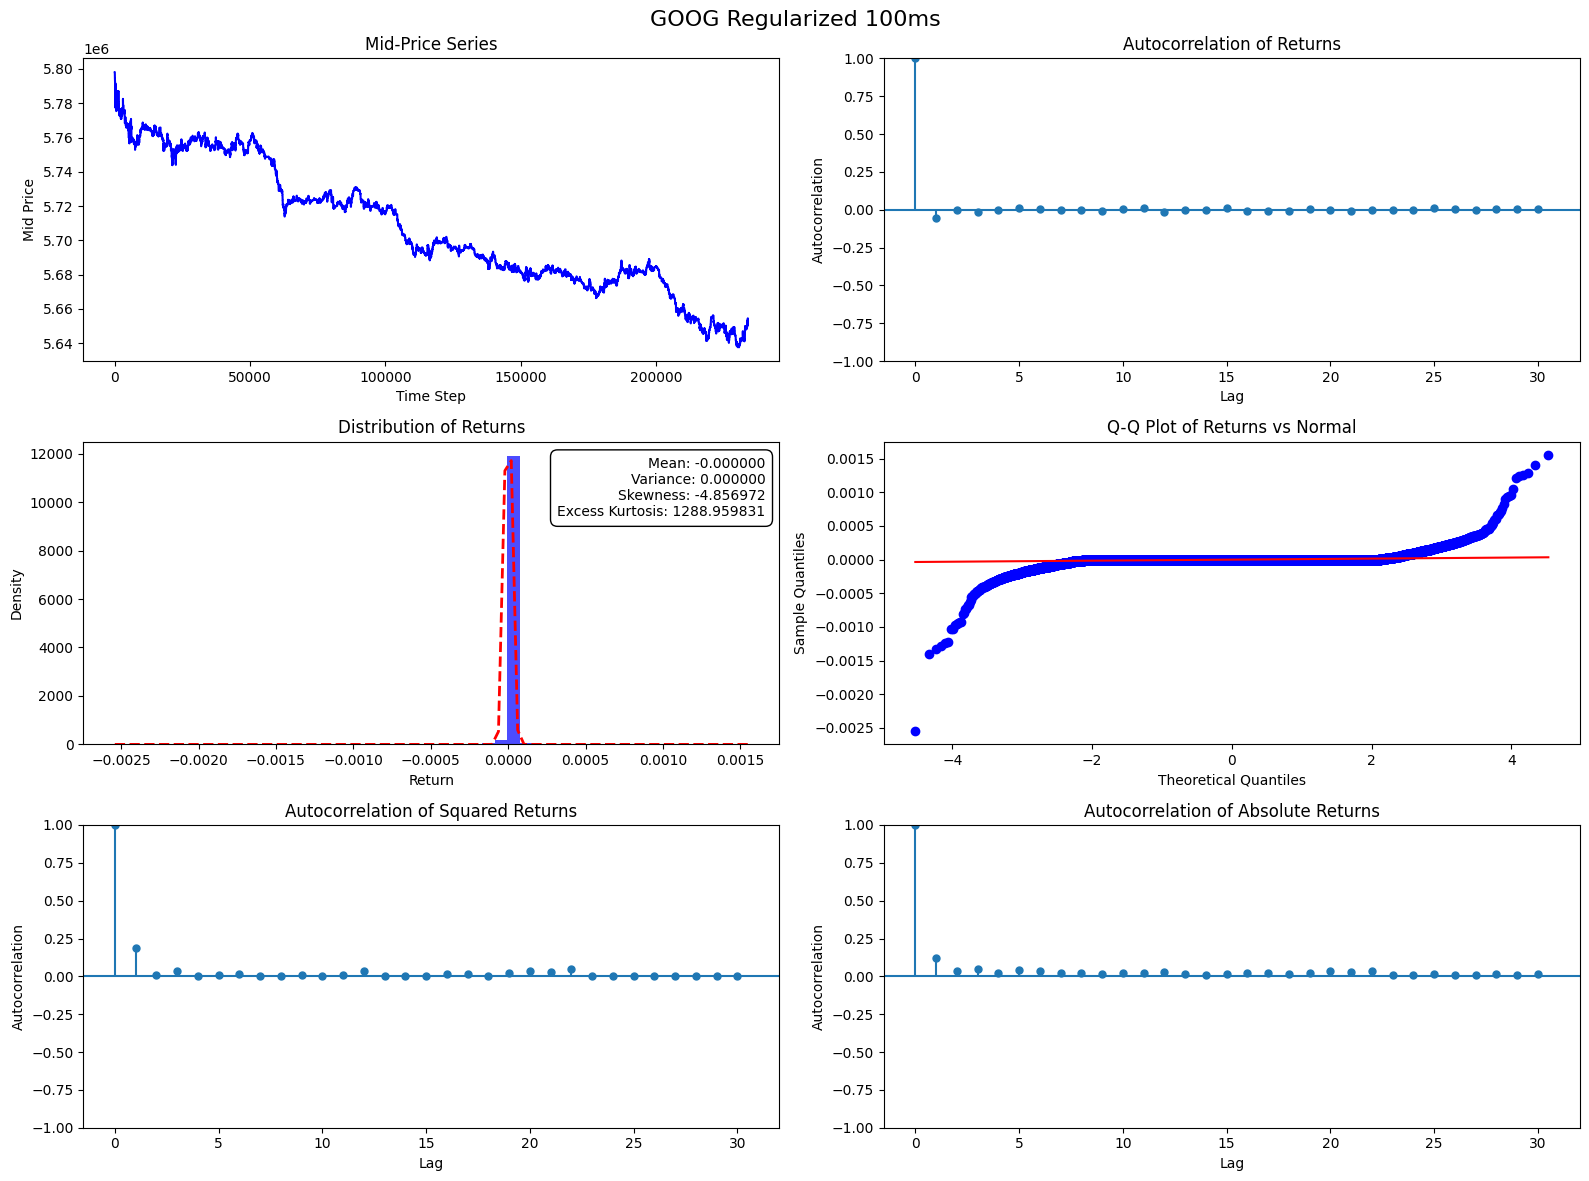

In [ ]:
regularized_book_data['MidPrice'] = (regularized_book_data['AskPrice1'] + regularized_book_data['BidPrice1']) / 2

# Calculate the difference between consecutive rows in the 'MidPrice' column
mid_price_diff = regularized_book_data['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count = (mid_price_diff == 0).sum()

# Calculate the percentage of zero changes
percentage_zero_changes = (zero_change_count / len(regularized_book_data)) * 100

print(f"Percentage of rows with no change in MidPrice: {percentage_zero_changes:.4f}%")

visualize_return(regularized_book_data['MidPrice'], "GOOG Stylized Facts Investigation for 2012-06-21 (100ms)")

Percentage of rows with no change in MidPrice in book_data: 83.7171%


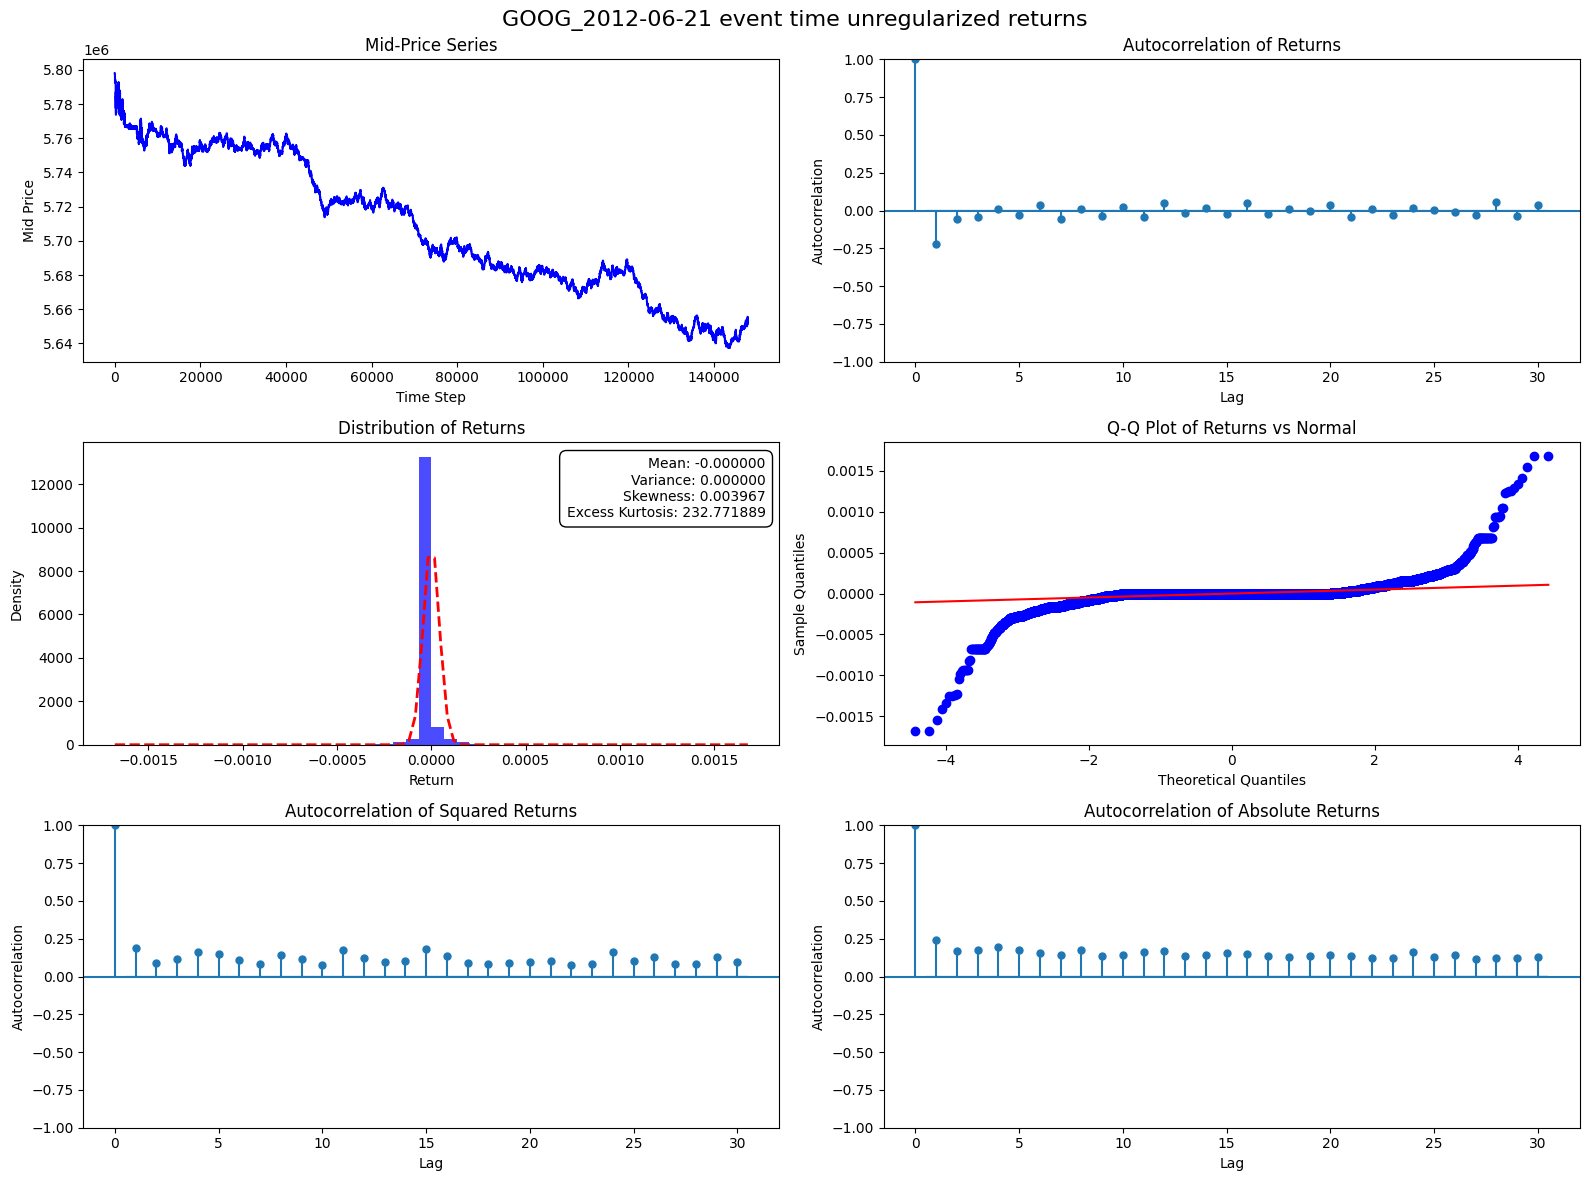

In [ ]:
book_data['MidPrice'] = (book_data['AskPrice1'] + book_data['BidPrice1']) / 2

# Filter

# Calculate the difference between consecutive rows in the 'MidPrice' column for book_data
mid_price_diff_original = book_data['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count_original = (mid_price_diff_original == 0).sum()

# Calculate the percentage of zero changes in book_data
percentage_zero_changes_original = (zero_change_count_original / len(book_data)) * 100

print(f"Percentage of rows with no change in MidPrice in book_data: {percentage_zero_changes_original:.4f}%")


visualize_return(book_data['MidPrice'], "GOOG Stylized Facts Investigation for 2012-06-21 (LOB Event Time)")

Percentage of rows with no change in MidPrice in market order events: 53.5965%
(11678, 42)


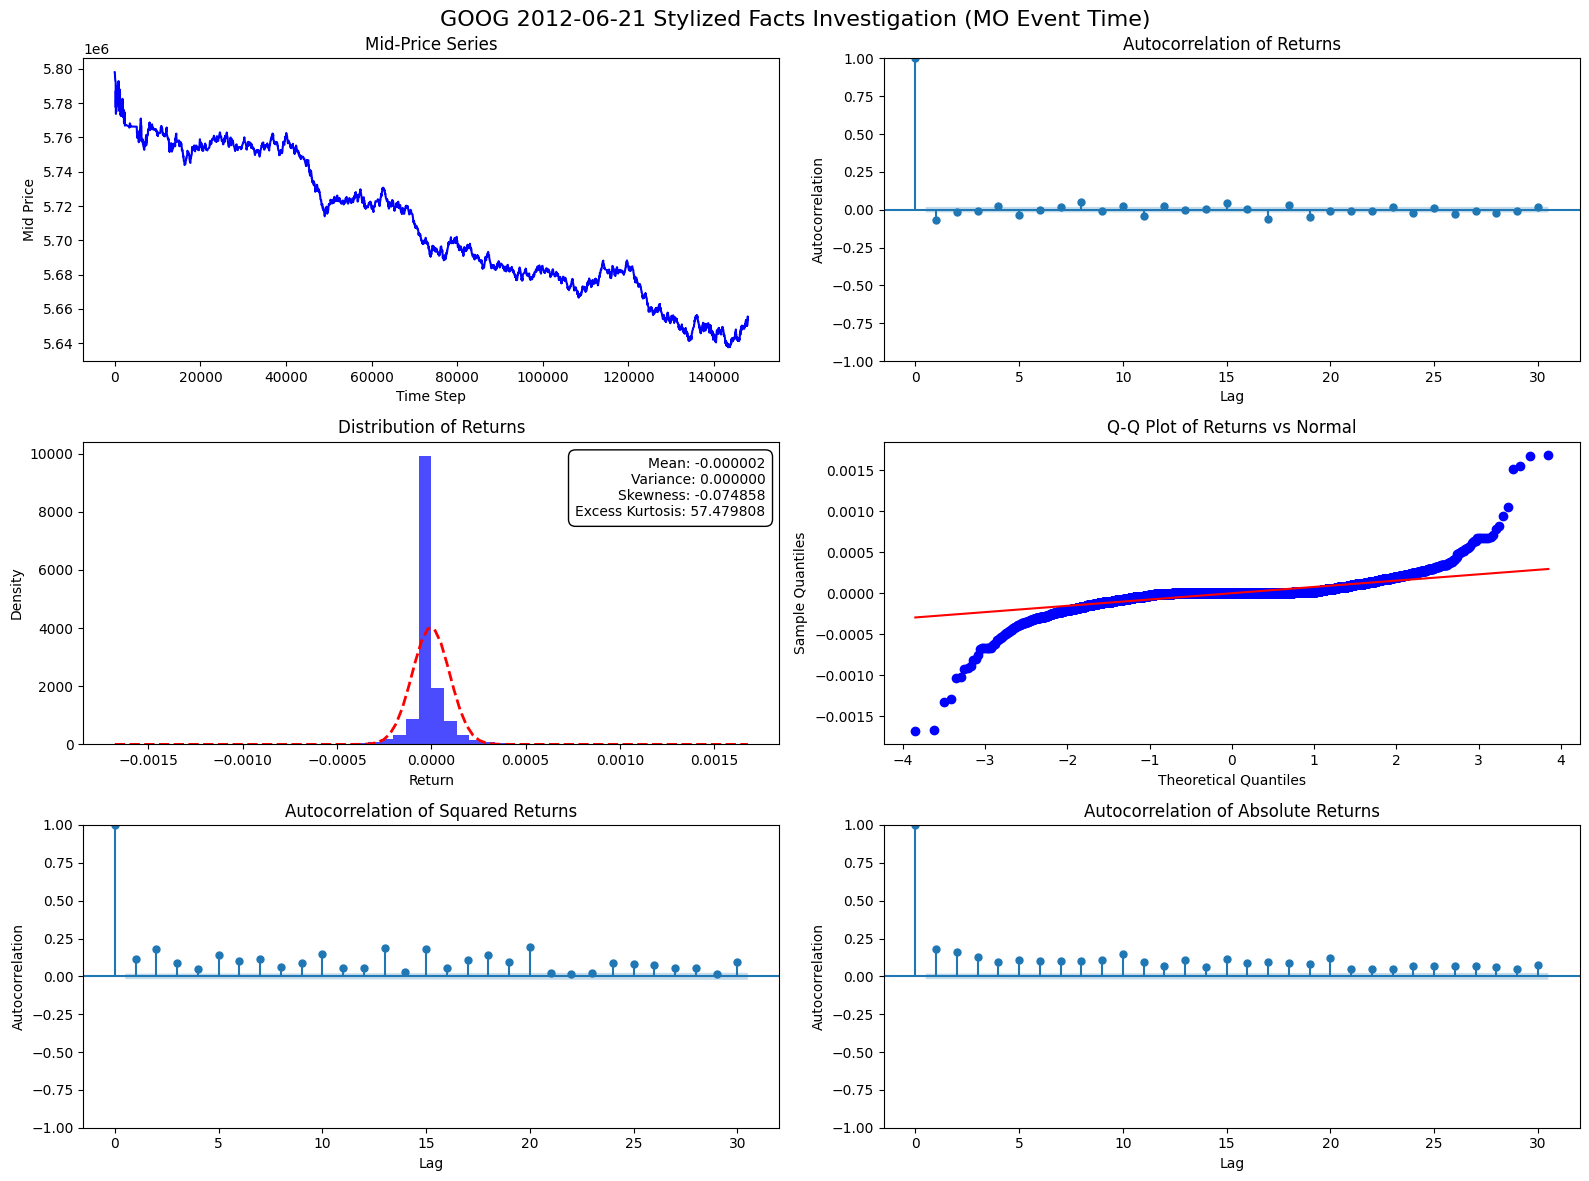

In [ ]:
# Step 1: Filter for market order events (EventType 4 and 5)
market_order_events = book_data[message_data['EventType'].isin([4, 5])].copy(deep=True)

# All midprice divided by 1e4 to scale to dollars
market_order_events['MidPrice'] = market_order_events['MidPrice'] / 1e4

# Step 2: Calculate the Mid-Price at each market order event
market_order_events['MidPrice'] = (market_order_events['AskPrice1'] + market_order_events['BidPrice1']) / 2

# Step 3: Calculate the difference between consecutive rows in the 'MidPrice' column
mid_price_diff_event_time = market_order_events['MidPrice'].diff()

# Count the number of rows where the difference is 0 (indicating no change from the previous row)
zero_change_count_event_time = (mid_price_diff_event_time == 0).sum()

# Calculate the percentage of zero changes in market order events
percentage_zero_changes_event_time = (zero_change_count_event_time / len(market_order_events)) * 100

# Print the result
print(f"Percentage of rows with no change in MidPrice in market order events: {percentage_zero_changes_event_time:.4f}%")

print(market_order_events.shape)

# Step 4: Visualize the return series for MidPrice at market order event times
visualize_return(market_order_events['MidPrice'], "GOOG 2012-06-21 Stylized Facts Investigation (MO Event Time)")